### CS 421 PROJECT

**Background & Objective**

In this project, you will be working with data extracted from famous recommender systems type datasets: you are provided with a large set of interactions between users (persons) and items (movies). Whenever a user "interacts" with an item, it watches the movie and gives a "rating". There are 4 possible ratings: "dislike", "neutral", "like", and "watched". The "watched" rating indicates that the user has rated the movie, but the specific rating is unknown (that means you know that the user has watched the movie, but you don't know whether they liked it).

In this exercise, we will **not** be performing the recommendation task per se. Instead, we will identify *anomalous users*. In the dataset that you are provided with, some of the data was corrupted. Whilst most of the data comes from real life user-item interactions from a famous movie rating website, some "users" are anomalous: they were generated by me according to some undisclosed procedure. Furthermore, there are **two types of anomalies** with two different generation procedures.

**Data**

You are provided with two data frames: the first one ("X") contains the interactions provided to you, and the second one ("yy") contains the labels for the users.

As you can see, the three columns in "X" correspond to the user ID, the item ID and the rating (encoded into numerical form). Thus, each row of "X" contains a single interaction. For instance, if the row "142, 152, 10" is present, this means that the user with ID 142 has given the movie 152 a positive rating of "like".

The table below shows what each numerical encoding of the rating corresponds to:

| Rating in X    | Meaning     |
| :------------- | :---------- |
| -10            | dislike     |
| 0              | neutral     |
| 10             | like        |
| 1              | watched     |

The dataframe "yy" has two columns. In the first column we have the user IDs, whilst the second column contains the labels. A label of 0 denotes a natural user (coming from real life interactions), whilst a label of 1 or 2 indicates an anomaly generated by me. The anomalies with label 1 are generated with a different procedure from the anomalies with label 2. 

For instance, if the labels matrix contains the line "142, 1", it means that ALL of the ratings given by the user with ID 142 are fake, and generated according to the first anomaly generation procedure. This means all lines in the dataframe "ratings" which start with the user ID 142 correspond to fake interactions. 

#### Evaluation

Your task is to be able to classify unseen instances as either anomalies or non anomalies (guess whether they are real users or if they were generated by me). As well as indicate which anomaly type they belong to. 

There are **far more** normal users than anomalies in the dataset, which makes this a very heavily **unbalanced dataset**. Thus, accuracy will not be a good measure of performance, since simply predicting that every user is normal will give good accuracy. Thus, we need to use some other evaluation metrics (see lecture notes from week 3). 

THE **EVALUATION METRIC** is:  THE **AUC** (AREA UNDER CURVE) for each class (thus, there are three performance measures, one for each class). The main final metric to evaluate the ranking will be the average of the three.  This means your programs should return a **score** for each user and anomaly type combination. For instance, your model's prediction for user 1200 should consist of three scores $z_0,z_1,z_2$ corresponding to the normal class and the two anomalous classes respectively. 

Every few weeks, we will evaluate the performance of each team (on a *test set with unseen labels* that I will provide) in terms of all three AUCs.

The difficulty implied by **the generation procedure of the anomalies MAY CHANGE as the project evolves: depending on how well the teams are doing, I may generate easier or harder anomalies**.

**Deliverables**

Together with this file, you are provided with a first batch of labelled examples "first_batch_multi_labels.npz". You are also provided with the test samples to rank by the next round (without labels) in the file "second_batch_multi.npz".

The **first round** will take place after recess (week 9): you must hand in your scores for the second batch before the **WEDNESDAY at NOON (15th of October)**. We will then look at the results together on the Thursday.  

We will check everyone's performance in this way every week (once on  week 10, once on week 11 and once on week 12). 

To summarise, the project deliverables are as follows:

- Before every checkpoint's deadline, you need to submit **a `.npz` file** containing a Numpy array of size $\text{number of test batch users} \times 3$, where the value of each cell corresponds to the predicted score of the user (row) belonging to the anomaly type (column). The order of rows should correspond to the user IDs. For example, if the test batch contains users 1100-2200, scores for user 1100 should be the first row (row 0), scores for user 1101 should be the second row (row 1), and so on.

- On Week 12-13 (schedule to be decided), you need to present your work in class. The presentation duration is **10 minutes** with 5 minutes of QA. 

- On Week 12, you need to submit your **Jupyter Notebook** (with comments in Markdown) and the **slides** for your presentation. 
- On week 13 you need to submit your **final report**. The final report should be 2-3 pages long (consisting of problem statement, literature review, and motivation of algorithm design) with unlimited references/appendix.

Whilst performance (expressed in terms of AUC and your ranking compared to other teams) at **each of the check points** (weeks 9 to 12 inclusive) is an **important component** of your **final grade**, the **final report** and the detail of the various methods you will have tried will **also** be very **important**. Ideally, to get perfect marks (A+), you should try at least **two supervised methods** and **two unsupervised methods**, as well as be ranked the **best team** in terms of performance. 


In addition, I will be especially interested in your **reasoning**. Especially high marks will be awarded to any team that is able to **qualitatively describe** the difference between the two anomaly types. You are also encouraged to compute statistics related to each class and describe what is different about them. 

In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data=np.load("first_batch_multi_labels.npz")

In [240]:
X=data["X"]
y=data["yy"]



XX=pd.DataFrame(X)
yy=pd.DataFrame(y)
XX.rename(columns={0:"user",1:"item",2:"rating"},inplace=True)

In [241]:
XX.head()

,user,item,rating
0,1073,3,1
1,1073,15,1
2,1073,24,1
3,1073,29,1
4,1073,33,10


In [242]:
print(XX)

        user  item  rating
0       1073     3       1
1       1073    15       1
2       1073    24       1
3       1073    29       1
4       1073    33      10
...      ...   ...     ...
179751   793   845     -10
179752   793   854       1
179753   793   862       1
179754   793   886       1
179755   793   890       1

[179756 rows x 3 columns]


In [243]:
yy.rename(columns={0:"user",1:"label"},inplace=True)

In [244]:
yy.head()

,user,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [338]:
merged_df = pd.merge(XX, yy, on='user')
merged_df.head()

,user,item,rating,label
0,1073,3,1,0
1,1073,15,1,0
2,1073,24,1,0
3,1073,29,1,0
4,1073,33,10,0


user_stats = merged_df.groupby('user')['rating'].agg([ 'sum', 'count']).reset_index()
user_stats.columns = ['user', 'total_rating', 'rating_count']
df = merged_df.merge(user_stats, on='user', how='left')

unique_label_count = df['label'].nunique()
print(f'Number of unique label: {unique_label_count}')
df.head()

In [509]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew, kurtosis
# Basic user features
df_user_features = merged_df.groupby('user').agg(
    mean_rating=('rating', 'mean'),
    #median_rating=('rating', 'median'),
    std_rating=('rating', 'std'),
    #this was the only thing i added, it was based off one of the features i added on my original one that made significant impact
    total_rating=('rating','sum'),
        
    count_dislike=('rating', lambda x: (x == -10).sum()),
    count_neutral=('rating', lambda x: (x == 0).sum()),
    count_like=('rating', lambda x: (x == 10).sum()),
    count_watched=('rating', lambda x: (x == 1).sum()),
    total_interactions=('rating', 'count')
)

# Ratio features
#df_user_features['like_ratio'] = df_user_features['count_like'] / df_user_features['total_interactions']
#df_user_features['dislike_ratio'] = df_user_features['count_dislike'] / df_user_features['total_interactions']
#df_user_features['neutral_ratio'] = df_user_features['count_neutral'] / df_user_features['total_interactions']
#df_user_features['watched_ratio'] = df_user_features['count_watched'] / df_user_features['total_interactions']
    
# Interaction patterns
#df_user_features['like_to_dislike_ratio'] = df_user_features['count_like'] / (df_user_features['count_dislike'] + 1)
#df_user_features['rating_variance'] = merged_df.groupby('user')['rating'].var()
    
# Distribution features
#df_user_features['rating_skew'] = merged_df.groupby('user')['rating'].apply(lambda x: skew(x))
#df_user_features['rating_kurtosis'] = merged_df.groupby('user')['rating'].apply(lambda x: kurtosis(x))
    
# User behavior patterns
#df_user_features['rating_range'] = merged_df.groupby('user')['rating'].apply(lambda x: x.max() - x.min())
#df_user_features['unique_items_ratio'] = merged_df.groupby('user')['item'].nunique() / df_user_features['total_interactions']
    

In [510]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

df = df_user_features
y = yy['label']
x = df
x.info()
print(y)

<class 'pandas.core.frame.DataFrame'>
Index: 1100 entries, 0 to 1099
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   std_rating          1100 non-null   float64
 1   total_rating        1100 non-null   int64  
 2   count_dislike       1100 non-null   int64  
 3   count_neutral       1100 non-null   int64  
 4   count_like          1100 non-null   int64  
 5   count_watched       1100 non-null   int64  
 6   total_interactions  1100 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 68.8 KB
0       0
1       0
2       0
3       0
4       0
       ..
1095    1
1096    0
1097    0
1098    1
1099    0
Name: label, Length: 1100, dtype: int64


In [511]:
x.head()

,std_rating,total_rating,count_dislike,count_neutral,count_like,count_watched,total_interactions
user,,,,,,,
0,6.167758,177,20,24,32,57,133
1,5.238997,149,8,26,19,39,92
2,7.380911,258,32,6,52,58,148
3,6.107906,155,36,48,43,85,212
4,4.686725,413,11,54,42,103,210


In [512]:
features = x.values[:,:]
features.shape

(1100, 7)

In [517]:
print(features)

[[   6.16775806  177.           20.         ...   32.
    57.          133.        ]
 [   5.23899661  149.            8.         ...   19.
    39.           92.        ]
 [   7.38091086  258.           32.         ...   52.
    58.          148.        ]
 ...
 [   6.12118071 -349.           87.         ...   37.
   151.          326.        ]
 [   3.61622446  208.            3.         ...   16.
    78.          126.        ]
 [   4.79519916  689.            3.         ...   64.
    79.          183.        ]]


In [519]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

model = AgglomerativeClustering(n_clusters = 3, linkage = "average", metric = "cosine")


In [521]:
model.fit(features)

AgglomerativeClustering(linkage='average', metric='cosine', n_clusters=3)

In [523]:
print(np.unique(model.labels_))

[0 1 2]


In [525]:
from sklearn.metrics import mean_squared_error
score = mean_squared_error(y,model.labels_)
abs_error = np.sqrt(score)
print(abs_error)

1.8150882773423045


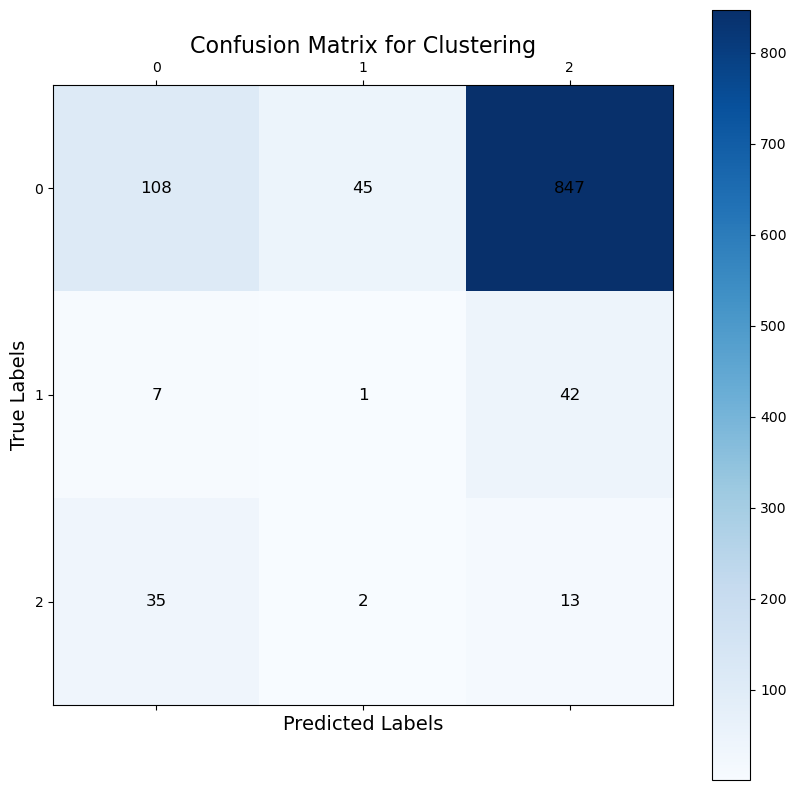

In [527]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y, model.labels_)
# Set figure size
fig, ax = plt.subplots(figsize=(10, 10))  # Larger figure for better display

# Display the matrix
cax = ax.matshow(cm, cmap="Blues")

# Add color bar
plt.colorbar(cax)

# Set axes labels
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix for Clustering", fontsize=16)

# Annotate each cell with the numeric value
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='black', fontsize=12)

# Show the plot
plt.show()